In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [4]:
import mmsplice
mmsplice.__version__

'1.0.1'

In [5]:
from mmsplice.exon_dataloader import ExonDataset
from mmsplice import MMSplice, predict_all_table, predict_save
from mmsplice.utils import get_var_side, logit, expit, transform
# import mmsplice
from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate
from scipy.stats import spearmanr, pearsonr
from mtsplice.utils.functional import nanpearsonr, nanspearmanr

In [6]:
import numpy as np
import pandas as pd
from mtsplice import get_data_dir
from mtsplice.utils.utils import abline
DATA = "../data/"
from mtsplice.data.ascot_dl import ascot_to_gtex_tissue_mapping, gtex_to_ascot_tissue_mapping, tissues
from mtsplice.utils.utils import get_var_side

In [7]:
from mmsplice.exon_dataloader import ExonDataset

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [9]:
csvf = pd.read_csv(DATA + "GTEx_variants.csv.gz", index_col=0)

In [10]:
csvf.shape

(1767, 121)

## Apply MMSplice

In [11]:
%matplotlib inline

In [12]:
dl = ExonDataset(DATA + "GTEx_variants.csv.gz",
                 DATA + "hg19.fa", 
                 split_seq=True, 
                 tissue_specific=True,
                 overhang=(300, 300))

In [13]:
dl_mmsplice = ExonDataset(DATA + "GTEx_variants.csv.gz",
                 DATA+"hg19.fa", 
                 split_seq=True, 
                 overhang=(300, 300))

In [14]:
model = MMSplice()
from mmsplice.mtsplice import MTSplice
mtsplice_model = MTSplice()

Instructions for updating:
Colocations handled automatically by placer.


2021-03-07 14:49:56,052 [WARNING] From /opt/modules/i12g/anaconda/3-5.0.1/envs/mtsplice_paper/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-03-07 14:49:56,765 [WARNING] From /opt/modules/i12g/anaconda/3-5.0.1/envs/mtsplice_paper/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
mmsplice_mtsplice = predict_all_table(model, dl)

4it [01:14, 19.10s/it]


In [16]:
mmsplice_dlogit = predict_all_table(model, dl_mmsplice)

4it [00:21,  5.10s/it]


In [17]:
mmsplice_dlogit = mmsplice_dlogit['delta_logit_psi'].values

In [18]:
var_tissues = csvf.columns.to_series()
var_tissues = var_tissues[[x.startswith("dPSI") for x in var_tissues]].values
var_tissues = sorted(var_tissues)

In [19]:
ref_psi = csvf[[tissue.replace('dPSI', 'WT_PSI') for tissue in var_tissues]].values
dpsi_measured = csvf[var_tissues].values
alt_psi = ref_psi + dpsi_measured
dlogit = logit(alt_psi) - logit(ref_psi)

In [20]:
ref_psi_mean = np.nanmean(ref_psi, axis=-1, keepdims=True)
alt_psi_pred = expit(mmsplice_dlogit[:,np.newaxis] + logit(ref_psi_mean))
mmsplice_dPSI_pred = alt_psi_pred - ref_psi

In [21]:
mmsplice_dPSI_pred.shape

(1767, 53)

(0.4791346243729196, 4.856911152953096e-69)


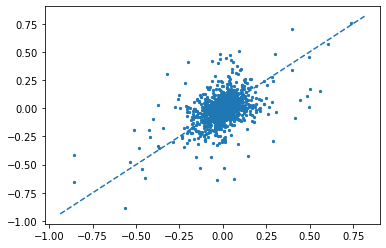

In [22]:
plt.scatter(mmsplice_dPSI_pred[:,0], (alt_psi-ref_psi)[:,0], s=5)
abline(1,0)
print(nanpearsonr(mmsplice_dPSI_pred[:,0], (alt_psi-ref_psi)[:,0]))
plt.show()

## MMSplice no tissue specificity, $\Psi_\text{ref}=mean(\Psi_{\text{tissue}})$

In [23]:
mmsplice_dPSI_pred = alt_psi_pred - ref_psi

## MMSplice + MTSplice

In [24]:
# mtsplice prediction align to gtex variant
gtex_index_in_ascot = [gtex_to_ascot_tissue_mapping[x.replace("dPSI", "")] for x in var_tissues]

In [25]:
# mmsplice_dlogit = delt_pred
psi_tissue_pred = expit(mmsplice_mtsplice[gtex_index_in_ascot].values + logit(ref_psi_mean))
dpsi_tissue_pred = psi_tissue_pred - ref_psi

In [26]:
from kipoi.writers import HDF5BatchWriter
HDF5BatchWriter.dump(DATA + "Variant_benchmark.h5",
                     {'ref_psi': ref_psi,
                      'alt_psi': alt_psi,
                      'MMSplice_MTSplice': dpsi_tissue_pred,
                      'MMSplice': mmsplice_dPSI_pred,
                      'dPSI_Measured': dpsi_measured})